In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from gumbel_V5_NS_shGLM import gumbel_NS_shGLM
from sklearn import metrics
import torch.distributions as dist

# Hyperparams

In [2]:
train_T = 65000
test_T = 15000
T_syn = 100
T_hist = 100
C_den = torch.zeros(5,5)
C_den[0,1:] = 1
#C_den = torch.zeros(1).reshape(1,1)
sub_no = C_den.shape[0]

batch_size = 1500

syn_basis_no = 2
hist_basis_no = 2
prop_basis_no = 2


In [3]:
Ensyn = torch.tensor([0, 106, 213, 211, 99])
Insyn = torch.tensor([1, 22, 36, 42, 19])
#Ensyn = torch.tensor([0+106+213+211+99])
#Insyn = torch.tensor([1+22+36+42+19])
E_no = torch.sum(Ensyn)
I_no = torch.sum(Insyn)

C_syn_e = torch.zeros(sub_no, E_no)
C_syn_i = torch.zeros(sub_no, I_no)

E_count = 0
for s in range(sub_no):
    C_syn_e[s,E_count:E_count+Ensyn[s]] = 1
    E_count += Ensyn[s]

I_count = 0
for s in range(sub_no):
    C_syn_i[s,I_count:I_count+Insyn[s]] = 1
    I_count += Insyn[s]

# Train Params

In [4]:
model = gumbel_NS_shGLM(C_den.cuda(), C_syn_e.cuda(), C_syn_i.cuda(), T_syn, syn_basis_no,
                T_hist, hist_basis_no, prop_basis_no)

model = model.float().cuda()

V_ref = np.load("/media/hdd01/sklee/tcn/L23_inputs/vdata_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b4.npy").flatten()

train_V_ref = V_ref[:train_T]
test_V_ref = V_ref[train_T:train_T+test_T]

test_V_ref = torch.from_numpy(test_V_ref).cuda()
train_V_ref = torch.from_numpy(train_V_ref)
print(test_V_ref.shape)

torch.Size([15000])


In [5]:
E_neural = np.load("/media/hdd01/sklee/tcn/L23_inputs/Espikes_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b4_neural.npy")
I_neural = np.load("/media/hdd01/sklee/tcn/L23_inputs/Ispikes_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b4_neural.npy")

train_S_E = E_neural[:train_T]
train_S_I = I_neural[:train_T]
test_S_E = E_neural[train_T:train_T+test_T]
test_S_I = I_neural[train_T:train_T+test_T]

train_S_E = torch.from_numpy(train_S_E)
train_S_I = torch.from_numpy(train_S_I)
test_S_E = torch.from_numpy(test_S_E).float().cuda()
test_S_I = torch.from_numpy(test_S_I).float().cuda()

In [6]:
repeat_no = 2
batch_no = (train_V_ref.shape[0] - batch_size) * repeat_no
train_idx = np.empty((repeat_no, train_V_ref.shape[0] - batch_size))
for i in range(repeat_no):
    part_idx = np.arange(train_V_ref.shape[0] - batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

print(batch_no)
print(train_idx.shape[0])

127000
127000


In [7]:
#optimizer = optim.Adam(model.parameters(), lr=0.00001)
optimizer = optim.Adam(model.parameters(), lr=0.005)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.5)


45


In [8]:
#batch_no = 10000
loss_array = np.empty((batch_no//100, 2))

for i in tnrange(batch_no):
    model.train()
    optimizer.zero_grad()
    batch_idx = train_idx[i].long()
    batch_S_E = train_S_E[batch_idx : batch_idx+batch_size].float().cuda()
    batch_S_I = train_S_I[batch_idx : batch_idx+batch_size].float().cuda()
    batch_pred= model(batch_S_E, batch_S_I)
    batch_ref = train_V_ref[batch_idx:batch_idx+batch_size].cuda()
        
    diff = (batch_ref - batch_pred) ** 1
    var_loss = torch.var(diff)

    
    loss = var_loss
    #print(i, var_loss.item(), torch.mean(batch_spikes).item())

        
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    if i%50 == 0:
        model.eval()
        test_pred = model(test_S_E, test_S_I)
        test_diff = (test_V_ref - test_pred) ** 1
        test_loss = torch.var(test_diff)
        
        test_score = metrics.explained_variance_score(y_true=test_V_ref.cpu().detach().numpy(),
                                                      y_pred=test_pred.cpu().detach().numpy(),
                                                      multioutput='uniform_average')
        train_score = metrics.explained_variance_score(y_true=batch_ref.cpu().detach().numpy(),
                                                      y_pred=batch_pred.cpu().detach().numpy(),
                                                      multioutput='uniform_average')
        print("TEST", i, test_loss.item(), test_score.item(), train_score.item())
        #print(torch.mean(test_spikes, 0).cpu().detach().numpy())
        #print(torch.mean(spike_probs, 0).cpu().detach().numpy())
        if i%100 == 0:
            torch.save(model.state_dict(), "/media/hdd01/sklee/cont_shglm/baseGLM_L23_sub5_b4_i"+str(i)+".pt")
            loss_array[i//100,0] = i
            loss_array[i//100,1] = test_score
            np.save("/media/hdd01/sklee/cont_shglm/baseGLM_L23_sub5_b4_test_scores.npy", loss_array)


<ipython-input-8-2994035fca1a>:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(batch_no):


TEST 0 40.31657653965878 5.0373504349998655e-06 -3.003481758456772e-05
TEST 50 37.369046737451875 0.07311429431189909 0.06191921753206653
TEST 100 34.16875676200879 0.15249290550452643 0.15747640909095306
TEST 150 31.594134873381083 0.2163527155356686 0.2021236073834657
TEST 200 29.58165285416787 0.2662694508775939 0.23947937549449538
TEST 250 27.80712253400909 0.3102841349879063 0.3000436213032177
TEST 300 26.34091958546079 0.34665120005312733 0.3624251537213976
TEST 350 25.634018779111088 0.3641848625595483 0.40353267686381555
TEST 400 23.922467633696666 0.40663743837703725 0.42897436081286044
TEST 450 22.696347689070535 0.4370495882362938 0.4260083182369655
TEST 500 21.66783750919083 0.4625603108015245 0.47816024491180686
TEST 550 21.836658765637555 0.45837294119581906 0.49010482702637337
TEST 600 19.91833766816843 0.5059541497040279 0.48898577816189814
TEST 650 19.005675870268835 0.5285914190201748 0.5181552882058322
TEST 700 18.259106187318544 0.5471090111744747 0.5189638689396692

TEST 6250 5.334621703624336 0.8676823458269203 0.7814881052558156
TEST 6300 5.817793468285121 0.8556979619336151 0.8308141153441352
TEST 6350 5.888539574530428 0.8539432060724764 0.8162661974843549
TEST 6400 5.542575602156473 0.8625243470854956 0.7486731986608735
TEST 6450 5.520419746619865 0.8630738913581858 0.7681666535222275
TEST 6500 5.671094580711411 0.8593366178000026 0.8408595712810779
TEST 6550 5.436435343334527 0.8651570042597779 0.8916382043372986
TEST 6600 5.43041890050917 0.8653062335364413 0.8263404736842641
TEST 6650 5.3043323059903065 0.8684336309702352 0.8804500935123706
TEST 6700 5.524505724437753 0.8629725445181635 0.8444458600533773
TEST 6750 5.25394245621225 0.8696834790742505 0.8707607780296872
TEST 6800 5.22117997288471 0.8704961055524284 0.7984326068560528
TEST 6850 5.23865562388228 0.8700626470601573 0.7628932658123513
TEST 6900 5.806840674415466 0.8559696302731048 0.755565828102307
TEST 6950 5.287186779294872 0.868858901241281 0.8266951351015867
TEST 7000 5.453

TEST 12450 5.373210214710033 0.8667252130374132 0.7914106543176078
TEST 12500 5.435275104288407 0.8651857823198137 0.8621620857910793
TEST 12550 4.912327419831117 0.8781567509913483 0.8911416976889013
TEST 12600 5.457552920461132 0.8646332129706038 0.7015886161860647
TEST 12650 4.9165234351979406 0.8780526748250529 0.8363926419199328
TEST 12700 4.860574212225672 0.8794404152040806 0.8356576057796419
TEST 12750 4.985969329739353 0.876330168822944 0.8416183744387821
TEST 12800 5.030208687564958 0.8752328748848364 0.8955682903773872
TEST 12850 5.16684687644216 0.8718437602425411 0.8003586720024581
TEST 12900 4.898481105021558 0.8785001890036843 0.8088310572059026
TEST 12950 4.867234198469975 0.8792752237796394 0.8537386629737025
TEST 13000 4.913756514503024 0.8781213043283826 0.7772481783165904
TEST 13050 4.84340988682881 0.8798661517339506 0.873737494914277
TEST 13100 5.232881957935174 0.8702058545541868 0.8637865815956028
TEST 13150 4.927222436777483 0.8777873014140717 0.848759139745568

TEST 18600 5.020174018798848 0.8754817704761142 0.818884478855232
TEST 18650 4.807214756452914 0.8807639201247934 0.8404626575862891
TEST 18700 4.917876506493078 0.8780191138230916 0.8536608365265331
TEST 18750 5.011239051473123 0.8757033895480936 0.8206396491651622
TEST 18800 4.787885559563469 0.8812433531819025 0.7636846971098664
TEST 18850 4.939878494430378 0.877473386008857 0.8367597743050554
TEST 18900 5.298496271595967 0.8685783854370088 0.8522700701418342
TEST 18950 4.8693021160479475 0.8792239320402612 0.8744075870016782
TEST 19000 5.119733170677195 0.873012348238035 0.8924500667622594
TEST 19050 4.949919127001361 0.8772243424956758 0.8146431457940034
TEST 19100 4.843310064752298 0.8798686276697358 0.8335595332783687
TEST 19150 4.835280498463177 0.880067789560844 0.7973039839441898
TEST 19200 4.807186931865683 0.8807646102605691 0.8585660584692575



KeyboardInterrupt: 

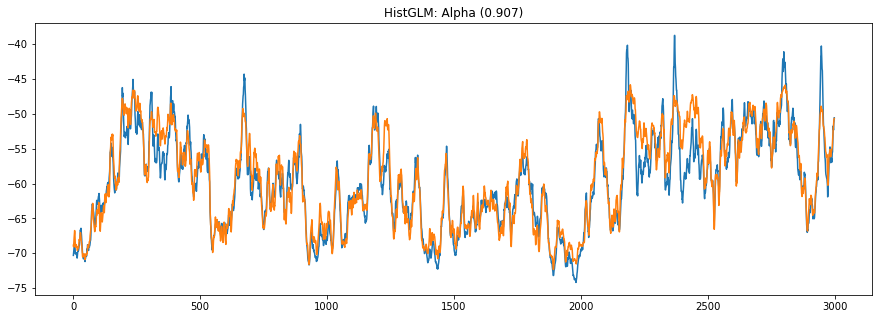

In [11]:
plt.figure(figsize=(15,5))
plt.plot(test_V_ref.cpu().detach().numpy()[3000:6000])
plt.plot(test_pred.cpu().detach().numpy()[3000:6000]-16)
plt.title("HistGLM: Alpha (0.907)")
plt.savefig("/media/hdd01/sklee/cont_shglm/histglmalpha_b4.png", dpi=150)

# Test 

In [4]:
model = gumbel_NS_shGLM(C_den.cuda(), C_syn_e.cuda(), C_syn_i.cuda(), T_syn, syn_basis_no,
                T_hist, hist_basis_no, prop_basis_no)

model.load_state_dict(torch.load("/media/hdd01/sklee/cont_shglm/baseGLM_L23_sub5_b4_i19200.pt"))
model = model.float().to("cuda")

V_ref = np.load("/media/hdd01/sklee/tcn/L23_inputs/vdata_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b4.npy").flatten()[:]

test_V_ref = V_ref[train_T:train_T+test_T]


In [5]:
E_neural = np.load("/media/hdd01/sklee/tcn/L23_inputs/Espikes_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b4_neural.npy")
I_neural = np.load("/media/hdd01/sklee/tcn/L23_inputs/Ispikes_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b4_neural.npy")

test_S_E = E_neural[train_T:train_T+test_T]
test_S_I = I_neural[train_T:train_T+test_T]

test_S_E = torch.from_numpy(test_S_E).float().cuda()
test_S_I = torch.from_numpy(test_S_I).float().cuda()

test_V_final = model(test_S_E, test_S_I)

test_V_final = test_V_final.cpu().detach().numpy()


0.9395138787590945


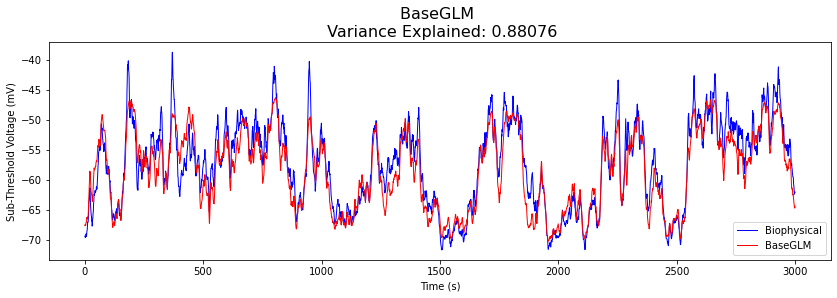

In [13]:
plt.figure(figsize = (14,4))
plt.plot(test_V_ref[5000:8000], label="Biophysical", c="blue", linewidth=1)
plt.plot(test_V_final[5000:8000]-17,label="BaseGLM", c="red", linewidth=1)
print(np.corrcoef(test_V_ref, test_V_final)[0][1])


test_score = metrics.explained_variance_score(y_true=test_V_ref,
                                                      y_pred=test_V_final,
                                                      multioutput='uniform_average')

plt.title("BaseGLM \n Variance Explained: " + str(round(test_score, 5)), fontsize = 16)
#plt.xticks(np.arange(0,8001,1000),[0,1,2,3,4,5,6,7,8])
#plt.xticks(np.arange(0,4001,1000),[0,1,2,3,4])
plt.xlabel("Time (s)")
plt.ylabel("Sub-Threshold Voltage (mV)")
plt.legend()
#plt.show()


#plt.savefig("/media/hdd01/sklee/cont_shglm/BaseGLM_L23_sub5_b4.png", dpi=150, bbox_inches='tight')#

In [14]:
#np.save("/media/hdd01/sklee/cont_shglm/baseglm_L23_sub5_b4_test.npy", test_V_final)

In [5]:
tau = model.Tau_syn.cpu().detach().numpy()
delta = model.Delta_syn.cpu().detach().numpy()
weights = model.W_syn.cpu().detach().numpy()

e_kern = np.zeros((sub_no, T_syn))
i_kern = np.zeros((sub_no, T_syn))

t = np.arange(T_syn)
for s in range(sub_no):
    t_e = t - delta[s,0]
    t_i = t - delta[s,1]
    t_e[t_e < 0.0] = 0.0
    t_i[t_i < 0.0] = 0.0
    for b in range(syn_basis_no):
        t_tau_e = t_e / np.exp(tau[b,0])
        t_tau_i = t_i / np.exp(tau[b,1])
        
        part_e_kern = t_tau_e * np.exp(-t_tau_e)
        part_i_kern = t_tau_i * np.exp(-t_tau_i)
        
        e_kern[s] += part_e_kern * weights[s,b,0]
        i_kern[s] += part_i_kern * weights[s,b,1]
        
for s in range(sub_no):
    e_kern[s] /= np.max(np.abs(e_kern[s]))
    i_kern[s] /= np.max(np.abs(i_kern[s]))

In [6]:
#np.save("/media/hdd01/sklee/cont_shglm/baseglm_L23_sub5_b4_e_kern.npy", e_kern)
#np.save("/media/hdd01/sklee/cont_shglm/baseglm_L23_sub5_b4_i_kern.npy", i_kern)

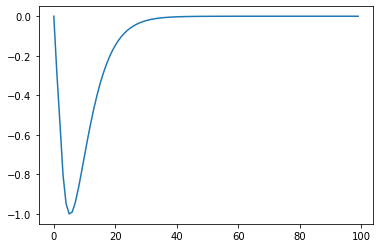

In [14]:
plt.plot(i_kern[2])